### jupyter Jupiter notebook for LDA (not current - see LDA.py)

In [1]:
%load_ext autoreload
%autoreload 2
from scripts.data_processing import *
from glob import glob
import os
import re
from wordcloud import WordCloud
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from eli5.sklearn import InvertableHashingVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import random



import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/home/ec2-user/.vscode-server-insiders/extensions/ms-python.python-2020.9.114305/pythonFiles/lib/python/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


#### script options

In [50]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


args = {'data_dir':'data',
        'num_posts':2500000, 
        'word_cloud' : True, 
        'load_vec' : True,
        'plot_10' : True,
        'n_features' : 40000,
        'topics' : 10,
        'lda_path' : False,
        'max_iter':10,
        'prepare_vis':True}

args = dotdict(args)


### Create post generator

In [2]:
data_path = os.path.join(args.data_dir, '*.bz2')
bzfile = glob(os.path.join('data','*.bz2'))
print(bzfile)
d = data_processing(bzfile, args.num_posts)

['data/RC_2011-08.bz2']


### Dat processing steps

In [3]:
data = [l for l in d]
# Remove punctuation
data = [re.sub('[,\\.!?]', '', x) for x in data]
# Convert the titles to lowercase
data = [x.lower() for x in data]
# Remove post with less than 10 words
data = [x for x in data if len(x.split(' '))>10]
# display some data
pprint(data[:3])

['i was thinking 170k max but if we get another player off the books (gibson) '
 'there would be a small bit more room to maneuver',
 'a baton is more likely to kill someone than a taser',
 'cut him a break he probably just finished watching training day ']


### Word Cloud visualization

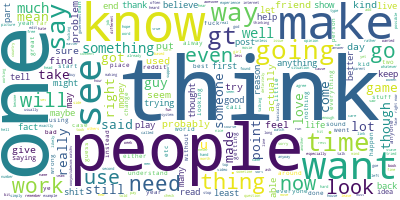

In [5]:
if args.wordcloud:

    long_string = ','.join(data)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Save the word cloud image
    wordcloud.to_file(os.path.join('results','wordcloud.png'))
    # Visualize the word cloud
    wordcloud.to_image()

### Word freq visualazation and count vectorizer

loading hash vectorizer... done
fitting invertable hash vectorizer... done
plotting top 10 in sample


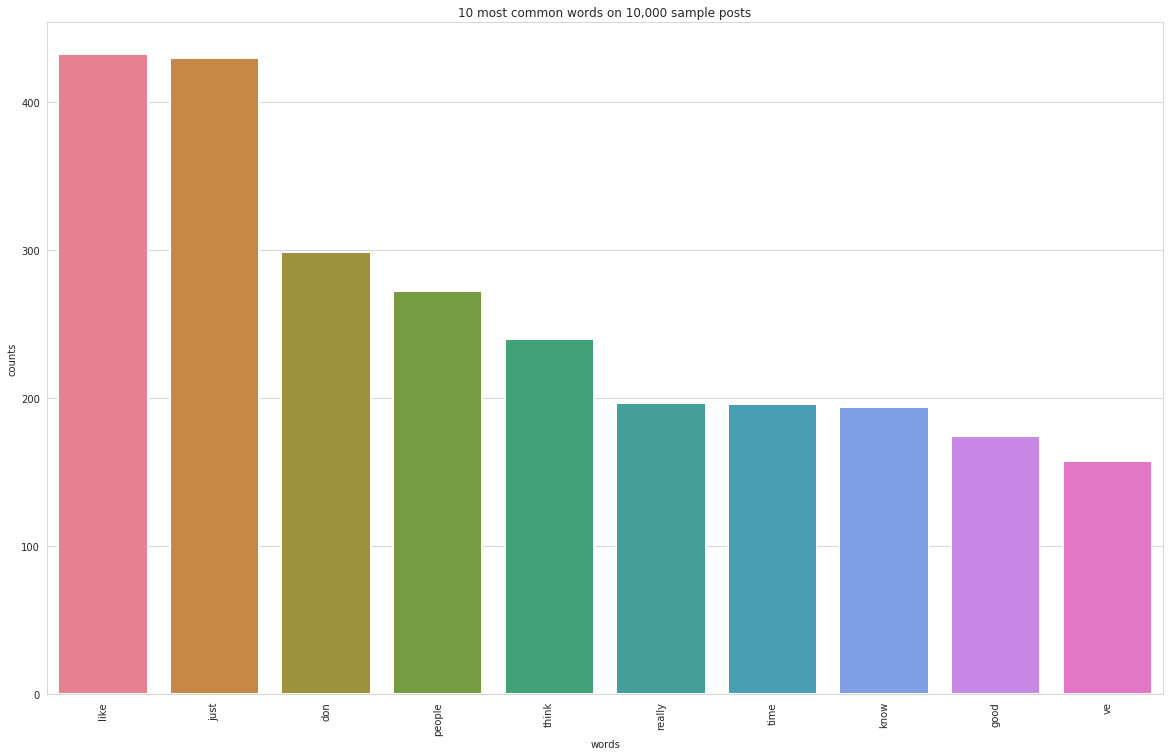

In [15]:

sns.set_style('whitegrid')
# get_ipython().run_line_magic('matplotlib', 'inline')
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0][0]['name'] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    ax = plt.figure(2, figsize=(20, 20/1.6180))
    plt.subplot(title='10 most common words on 10,000 sample posts')
    sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.savefig(os.path.join('results','top10words.png'), bbox_inches='tight', facecolor='white')
    plt.show()
# Initialise the count vectorizer with the English stop words
# count_vectorizer = CountVectorizer(stop_words='english')


if args.load_vec:
    print('loading hash vectorizer...', end=' ')
    hash_vectorizer = pickle.load(open(os.path.join('models','hash_vect.pk'), 'rb'))
    hash_data = hash_vectorizer.transform(data)
    print('done')
else: 
    print('fitting hash vectorizer...', end=' ')
    hash_vectorizer = HashingVectorizer(stop_words='english',
                                        alternate_sign=False, 
                                        n_features=args.n_features)
    hash_data = hash_vectorizer.fit_transform(data)
    print('done')
    print('saving hash vectorizer ...', end='')
    pickle.dump(hash_vectorizer, open(os.path.join('models','hash_vect.pk'), 'wb'))
    print('done')


ivec = InvertableHashingVectorizer(hash_vectorizer)
sample_size = 10000
X_sample = random.sample(data, k=sample_size)
print('fitting invertable hash vectorizer...', end=' ')
count_sample = ivec.fit_transform(X_sample)
print('done')
# # Fit and transform the processed titles
# count_data = count_vectorizer.fit_transform(data)

# Visualize the 10 most common words
#plot_10_most_common_words(count_data, count_vectorizer)


if args.plot_10:
    print('plotting top 10 in sample')
    plot_10_most_common_words(count_sample, ivec)

### LDA model fit

In [27]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

def lda_experiment(number_topics, hash_data, max_iter):
    print(f'fitting the LDA model with {number_topics} topics')
    lda = LDA(n_components=number_topics,
            learning_method='online',
            max_iter=max_iter, 
            evaluate_every=5,
            batch_size=128**2, 
            verbose=1,
            n_jobs=-1)
    return lda.fit(hash_data)

        

number_topics = args.topics
if args.lda_path:
    lda = pickle.load(open(args.lda_path, 'rb'))
else:
    # Create and fit the LDA model
    lda = lda_experiment(args.topics, hash_data, args.max_iter)
    # save model
    print('saving LDA model ...', end='')
    pickle.dump(lda, open(os.path.join('models',f'lda_model_{args.number_topics}.pk'), 'wb'))
    print('done')

fitting the LDA model with 10 topics
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10, perplexity: 9932.9432
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 9914.3869
saving LDA model ...done


In [51]:

def prepare_vis(lda, count_sample, ivec,number_topics):
    print('preparing LDAvis...', end=' ')
    LDAvis_data_filepath = os.path.join('results','./ldavis_prepared_'+str(number_topics))
    # # this is a bit time consuming 
    LDAvis_prepared = sklearn_lda.prepare(lda, count_sample, ivec)
    pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath +'.html')
    print('done')

if args.prepare_vis:
    prepare_vis(lda, count_sample, ivec,args.topics)


preparing LDAvis... done


In [36]:
count_sample[20]

<1x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [70]:
from git import Repo

# rorepo is a Repo instance pointing to the git-python repository.
# For all you know, the first argument to Repo is a path to the repository
# you want to work with
repo = Repo('..')
assert not repo.bare

In [73]:

# PATH_OF_GIT_REPO = r'path\to\your\project\folder\.git'  # make sure .git folder is properly configured
COMMIT_MESSAGE = 'comment from python script'

def git_push():
    try:
        # repo = Repo(PATH_OF_GIT_REPO)
        repo.git.add(update=True)
        repo.index.commit(COMMIT_MESSAGE)
        origin = repo.remote(name='origin')
        origin.push()
    except Exception as E:
        print('Some error occured while pushing the code', E)    

git_push()  

Some error occured while pushing the code Cmd('git') failed due to: exit code(128)
  cmdline: git push --porcelain origin
  stderr: 'fatal: could not read Username for 'https://github.com': No such device or address'
